# Battery Forecasting with DeepAR

In this notebook we'll prevent battery outages using Amazon Sagemaker and [DeepAR Forecasting](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html).

"The Amazon SageMaker DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNN)."

Start by loading the required libraries and recovering stored data:

In [1]:
import pandas as pd
from matplotlib import pyplot

In [2]:
%store -r data

## Exploratory Data Analysis

Visualize the battery time series for a single device:

In [3]:
device_loc = 1
sample_device_id = data.iloc[device_loc]["device_id"]
sample_device_id

'8e4a851ed2317a249a0903f29d894361'

In [4]:
sample_data = data[data["device_id"] == sample_device_id]

In [5]:
battery = sample_data["battery"]

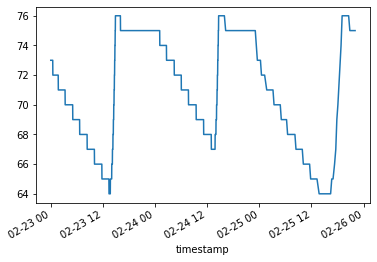

In [6]:
battery.plot()
pyplot.show()

## Time Series Resampling

The [DeepAR input format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput) requires data to be sampled at regular time intervals. Here is a sample input:


<code>{"start": "2009-11-01 00:00:00", "target": [4.3, "NaN", 5.1, ...], "cat": [0, 1], "dynamic_feat": [[1.1, 1.2, 0.5, ...]]}
{"start": "2012-01-30 00:00:00", "target": [1.0, -5.0, ...], "cat": [2, 3], "dynamic_feat": [[1.1, 2.05, ...]]}
{"start": "1999-01-30 00:00:00", "target": [2.0, 1.0], "cat": [1, 4], "dynamic_feat": [[1.3, 0.4]]}
</code>

In the dataset, we can see that the sample timestamps are no regularly spaced, but actualy reflects the observation time:

In [7]:
battery.tail()

timestamp
2020-02-25 20:50:37    75
2020-02-25 21:07:07    75
2020-02-25 21:23:15    75
2020-02-25 21:38:36    75
2020-02-25 22:03:11    75
Name: battery, dtype: int64

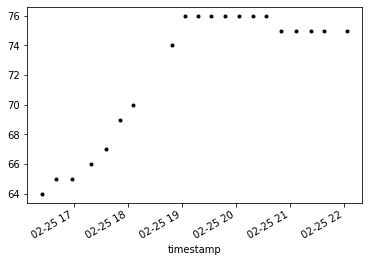

In [8]:
battery.tail(20).plot(style="k.")

Also, note that observation are taken about every 5 minutes, but changing little.
Pandas offers a convenient resampling function to create a uniform hourly dataset:

In [9]:
hourly = data[data["battery"] > 0]
hourly = (hourly.groupby("device_id")
          .battery
          .resample("H")
          .min())

In [10]:
hourly

device_id                         timestamp          
0001495ce5f079703599a94c32dab2b0  2020-02-24 15:00:00    75.0
                                  2020-02-24 16:00:00    75.0
                                  2020-02-24 17:00:00    75.0
                                  2020-02-24 18:00:00    75.0
                                  2020-02-24 19:00:00    75.0
                                                         ... 
fffaee1fbb9c96703850f64d3262e843  2020-02-25 17:00:00    64.0
                                  2020-02-25 18:00:00    68.0
                                  2020-02-25 19:00:00    75.0
                                  2020-02-25 20:00:00    76.0
                                  2020-02-25 21:00:00    76.0
Name: battery, Length: 532029, dtype: float64

In [11]:
hourly = hourly.reset_index().set_index("timestamp")

In [12]:
hourly

,device_id,battery
timestamp,,
2020-02-24 15:00:00,0001495ce5f079703599a94c32dab2b0,75.0
2020-02-24 16:00:00,0001495ce5f079703599a94c32dab2b0,75.0
2020-02-24 17:00:00,0001495ce5f079703599a94c32dab2b0,75.0
2020-02-24 18:00:00,0001495ce5f079703599a94c32dab2b0,75.0
2020-02-24 19:00:00,0001495ce5f079703599a94c32dab2b0,75.0
...,...,...
2020-02-25 17:00:00,fffaee1fbb9c96703850f64d3262e843,64.0
2020-02-25 18:00:00,fffaee1fbb9c96703850f64d3262e843,68.0
2020-02-25 19:00:00,fffaee1fbb9c96703850f64d3262e843,75.0


Let's again visualize a sample tame series:

In [13]:
hsample = hourly[hourly["device_id"] == sample_device_id]

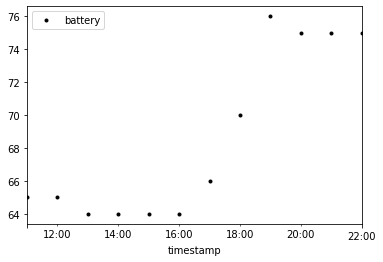

In [14]:
hsample.tail(12).plot(style="k.")

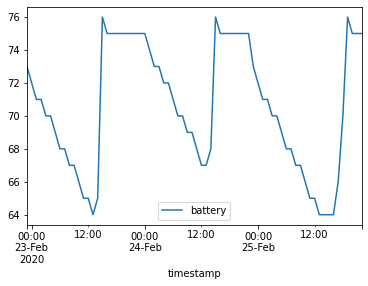

In [15]:
hsample.plot()

## Cross Validation

Take the last hours in the dataset for testing against predictions. This lets you evaluate how your model will perform on new data.

In [16]:
last_time = hourly.tail(1).index[0]
last_time

Timestamp('2020-02-25 21:00:00')

In [17]:
cut_time = last_time - pd.Timedelta('3 hour')
cut_time

Timestamp('2020-02-25 18:00:00')

In [18]:
train_set = hourly.loc[hourly.index <= cut_time]
train_set.tail()

,device_id,battery
timestamp,,
2020-02-25 14:00:00,fffaee1fbb9c96703850f64d3262e843,62.0
2020-02-25 15:00:00,fffaee1fbb9c96703850f64d3262e843,62.0
2020-02-25 16:00:00,fffaee1fbb9c96703850f64d3262e843,62.0
2020-02-25 17:00:00,fffaee1fbb9c96703850f64d3262e843,64.0
2020-02-25 18:00:00,fffaee1fbb9c96703850f64d3262e843,68.0


In [19]:
test_set = hourly.loc[hourly.index > cut_time]
test_set.head()

,device_id,battery
timestamp,,
2020-02-25 19:00:00,0001495ce5f079703599a94c32dab2b0,76.0
2020-02-25 20:00:00,0001495ce5f079703599a94c32dab2b0,76.0
2020-02-25 21:00:00,0001495ce5f079703599a94c32dab2b0,76.0
2020-02-25 19:00:00,00134c004e33e830e5dbce3355a485b9,76.0
2020-02-25 20:00:00,00134c004e33e830e5dbce3355a485b9,76.0


In [20]:
sample_train = train_set[train_set["device_id"] == sample_device_id]["battery"]
sample_test = test_set[test_set["device_id"] == sample_device_id]

In [21]:
sample_train.tail()

timestamp
2020-02-25 14:00:00    64.0
2020-02-25 15:00:00    64.0
2020-02-25 16:00:00    64.0
2020-02-25 17:00:00    66.0
2020-02-25 18:00:00    70.0
Name: battery, dtype: float64

In [22]:
sample_test.head()

,device_id,battery
timestamp,,
2020-02-25 19:00:00,8e4a851ed2317a249a0903f29d894361,76.0
2020-02-25 20:00:00,8e4a851ed2317a249a0903f29d894361,75.0
2020-02-25 21:00:00,8e4a851ed2317a249a0903f29d894361,75.0
2020-02-25 22:00:00,8e4a851ed2317a249a0903f29d894361,75.0


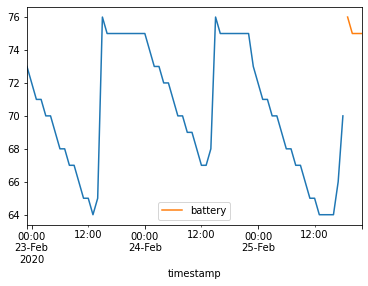

In [23]:
ax = sample_train.plot()
sample_test.plot(ax=ax)

## DeepAR Data Formatting

Convert the data from pandas DataFrame to the expeted JSON Lines:

In [24]:
import json
import math

def df_to_tss(dataframe):
    df = dataframe.copy()
    df["timeindex"] = df.index
    cats = {}
    tss = {}
    for index, row in df.iterrows():
        target = row["battery"]
        if not(math.isnan(target)):
            identity = row["device_id"]
            cat = cats.get(identity)
            if not cat:
                cat = len(cats)
                start = str(row["timeindex"])
                ts = {
                    "start": start,
                    "cat": [cat],
                    "target": [],
                }
                cats[identity] = cat
                tss[cat] = ts
            ts = tss.get(cat)
            ts["target"].append(target)
    return tss

def tss_to_jsonl(tss):  
    result = ""
    for key, value in tss.items():
        jsonll = json.dumps(value)
        result += jsonll
        result += "\n"
    return result[:-1]

def df_to_jsonl(dataframe):
    return tss_to_jsonl(df_to_tss(dataframe))

In [25]:
import time
start = time.time()
jsonl = df_to_jsonl(train_set.head(100))
elapsed = time.time() - start
print(elapsed)
print(jsonl)

0.017743587493896484
{"start": "2020-02-24 15:00:00", "cat": [0], "target": [75.0]}
{"start": "2020-02-24 15:00:00", "cat": [1], "target": [76.0, 75.0, 75.0, 74.0, 74.0, 75.0, 75.0, 75.0, 73.0, 72.0, 71.0, 71.0, 70.0, 69.0, 69.0, 68.0, 68.0, 67.0, 66.0, 66.0, 65.0, 65.0, 64.0, 64.0, 63.0, 64.0, 65.0, 69.0]}
{"start": "2020-02-24 15:00:00", "cat": [2], "target": [75.0, 75.0, 75.0, 74.0, 74.0, 75.0, 75.0, 75.0, 73.0, 72.0, 71.0, 71.0, 70.0, 69.0, 68.0, 68.0, 67.0, 67.0, 66.0, 66.0, 65.0, 64.0, 64.0, 63.0, 63.0, 63.0, 65.0, 68.0]}
{"start": "2020-02-24 15:00:00", "cat": [3], "target": [76.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 73.0, 72.0, 72.0, 71.0, 70.0, 70.0, 69.0, 69.0]}


In [26]:
import time
start = time.time()

train_tss = df_to_tss(train_set)
train_jsonl = tss_to_jsonl(train_tss)

test_tss = df_to_tss(test_set)
test_jsonl = tss_to_jsonl(test_tss)

elapsed = time.time() - start
print(elapsed)

68.25048232078552


Save the json lines files locally:

In [27]:
import pathlib

prefix = "mt-battery-deepar"
input_path = "./{}/input".format(prefix)

train_path = "{}/train.json".format(input_path)
test_path = "{}/test.json".format(input_path)
(train_path,test_path)

('./mt-battery-deepar/input/train.json', './mt-battery-deepar/input/test.json')

In [28]:
import shutil

shutil.rmtree(input_path, ignore_errors=True)
pathlib.Path(input_path).mkdir(parents=True, exist_ok=True)

In [29]:
with open(train_path, "w") as text_file:
    print(train_jsonl, file=text_file)

with open(test_path, "w") as text_file:
    print(test_jsonl, file=text_file)

In [30]:
! ls -liah "{input_path}/"

total 5.0M
1048684 drwxrwxr-x 2 ec2-user ec2-user 4.0K May 14 08:26 .
1048683 drwxrwxr-x 3 ec2-user ec2-user 4.0K May 14 08:26 ..
1048686 -rw-rw-r-- 1 ec2-user ec2-user 1.3M May 14 08:26 test.json
1048685 -rw-rw-r-- 1 ec2-user ec2-user 3.8M May 14 08:26 train.json


Upload train and test sets to S3:

In [31]:
%store -r bucket

In [32]:
!aws s3 sync "{input_path}/" "s3://{bucket}/{prefix}/" --delete

upload: mt-battery-deepar/input/test.json to s3://mt-ml-workshop-pi1g9mn3/mt-battery-deepar/test.json
upload: mt-battery-deepar/input/train.json to s3://mt-ml-workshop-pi1g9mn3/mt-battery-deepar/train.json


In [33]:
!aws s3 ls "s3://{bucket}/{prefix}/" 

2020-05-14 08:26:43    1325499 test.json
2020-05-14 08:26:43    3906490 train.json


In [34]:
dar_input = {
    "train": "s3://{}/{}/train.json".format(bucket,prefix),
    "test": "s3://{}/{}/test.json".format(bucket,prefix)
}
dar_input

{'train': 's3://mt-ml-workshop-pi1g9mn3/mt-battery-deepar/train.json',
 'test': 's3://mt-ml-workshop-pi1g9mn3/mt-battery-deepar/test.json'}

## DeepAR Training

The different [ML instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/) in training lets you control how efficiently models learn.

"You can train DeepAR on both GPU and CPU instances and in both single and multi-machine settings. We recommend starting with a single CPU instance (for example, ml.c4.2xlarge or ml.c4.4xlarge), and switching to GPU instances and multiple machines only when necessary."

In [35]:
# train_instance_type='ml.c5.2xlarge' #Estimated Training Time: 10m
train_instance_type='ml.m5.large'

In [36]:
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri

dar_image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')
dar_image_name

'224300973850.dkr.ecr.eu-west-1.amazonaws.com/forecasting-deepar:1'

In [37]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

dar_estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=dar_image_name,
    role=role,
    train_instance_count=1,
    train_instance_type=train_instance_type,
    base_job_name=prefix,
    output_path="s3://{}/{}/output/".format(bucket,prefix)
)

In [38]:
freq = 'H'
prediction_length = 4
context_length = 12

In [39]:

dar_hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
    "cardinality": "auto",
    "num_dynamic_feat":"ignore"
}
dar_estimator.set_hyperparameters(**dar_hyperparameters)

In [40]:
dar_estimator.fit(inputs=dar_input)

2020-05-14 08:26:44 Starting - Starting the training job...
2020-05-14 08:26:45 Starting - Launching requested ML instances...
2020-05-14 08:27:44 Starting - Preparing the instances for training......
2020-05-14 08:28:28 Downloading - Downloading input data...
2020-05-14 08:29:11 Training - Downloading the training image..Arguments: train
[05/14/2020 08:29:27 INFO 140074512123712] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[05/14/2020 08:29:27 I

[05/14/2020 08:29:41 INFO 140074512123712] Epoch[0] Batch[290] avg_epoch_loss=2.037886
[05/14/2020 08:29:41 INFO 140074512123712] #quality_metric: host=algo-1, epoch=0, batch=290 train loss <loss>=1.44603149891
[05/14/2020 08:29:41 INFO 140074512123712] Epoch[0] Batch [290]#011Speed: 708.56 samples/sec#011loss=1.446031
[05/14/2020 08:29:42 INFO 140074512123712] Epoch[0] Batch[295] avg_epoch_loss=2.028821
[05/14/2020 08:29:42 INFO 140074512123712] #quality_metric: host=algo-1, epoch=0, batch=295 train loss <loss>=1.50119969845
[05/14/2020 08:29:42 INFO 140074512123712] Epoch[0] Batch [295]#011Speed: 1074.76 samples/sec#011loss=1.501200
[05/14/2020 08:29:42 INFO 140074512123712] Epoch[0] Batch[300] avg_epoch_loss=2.018426
[05/14/2020 08:29:42 INFO 140074512123712] #quality_metric: host=algo-1, epoch=0, batch=300 train loss <loss>=1.40305635929
[05/14/2020 08:29:42 INFO 140074512123712] Epoch[0] Batch [300]#011Speed: 786.33 samples/sec#011loss=1.403056
[05/14/2020 08:29:42 INFO 1400745121

[05/14/2020 08:29:52 INFO 140074512123712] Epoch[1] Batch[10] avg_epoch_loss=1.484978
[05/14/2020 08:29:52 INFO 140074512123712] #quality_metric: host=algo-1, epoch=1, batch=10 train loss <loss>=1.51888084412
[05/14/2020 08:29:52 INFO 140074512123712] Epoch[1] Batch [10]#011Speed: 785.99 samples/sec#011loss=1.518881
[05/14/2020 08:29:52 INFO 140074512123712] Epoch[1] Batch[15] avg_epoch_loss=1.435044
[05/14/2020 08:29:52 INFO 140074512123712] #quality_metric: host=algo-1, epoch=1, batch=15 train loss <loss>=1.32518973351
[05/14/2020 08:29:52 INFO 140074512123712] Epoch[1] Batch [15]#011Speed: 1079.42 samples/sec#011loss=1.325190
[05/14/2020 08:29:52 INFO 140074512123712] Epoch[1] Batch[20] avg_epoch_loss=1.414286
[05/14/2020 08:29:52 INFO 140074512123712] #quality_metric: host=algo-1, epoch=1, batch=20 train loss <loss>=1.34786183834
[05/14/2020 08:29:52 INFO 140074512123712] Epoch[1] Batch [20]#011Speed: 771.13 samples/sec#011loss=1.347862
[05/14/2020 08:29:52 INFO 140074512123712] Ep

[05/14/2020 08:30:02 INFO 140074512123712] Epoch[1] Batch[280] avg_epoch_loss=1.444673
[05/14/2020 08:30:02 INFO 140074512123712] #quality_metric: host=algo-1, epoch=1, batch=280 train loss <loss>=1.46958293915
[05/14/2020 08:30:02 INFO 140074512123712] Epoch[1] Batch [280]#011Speed: 1007.64 samples/sec#011loss=1.469583
[05/14/2020 08:30:02 INFO 140074512123712] Epoch[1] Batch[285] avg_epoch_loss=1.444809
[05/14/2020 08:30:02 INFO 140074512123712] #quality_metric: host=algo-1, epoch=1, batch=285 train loss <loss>=1.45241003036
[05/14/2020 08:30:02 INFO 140074512123712] Epoch[1] Batch [285]#011Speed: 771.62 samples/sec#011loss=1.452410
[05/14/2020 08:30:02 INFO 140074512123712] Epoch[1] Batch[290] avg_epoch_loss=1.443204
[05/14/2020 08:30:02 INFO 140074512123712] #quality_metric: host=algo-1, epoch=1, batch=290 train loss <loss>=1.35140810013
[05/14/2020 08:30:02 INFO 140074512123712] Epoch[1] Batch [290]#011Speed: 1049.01 samples/sec#011loss=1.351408
[05/14/2020 08:30:02 INFO 140074512

[05/14/2020 08:30:12 INFO 140074512123712] Epoch[1] Batch[555] avg_epoch_loss=1.520889
[05/14/2020 08:30:12 INFO 140074512123712] #quality_metric: host=algo-1, epoch=1, batch=555 train loss <loss>=1.35359375477
[05/14/2020 08:30:12 INFO 140074512123712] Epoch[1] Batch [555]#011Speed: 988.88 samples/sec#011loss=1.353594
[05/14/2020 08:30:12 INFO 140074512123712] Epoch[1] Batch[560] avg_epoch_loss=1.518649
[05/14/2020 08:30:12 INFO 140074512123712] #quality_metric: host=algo-1, epoch=1, batch=560 train loss <loss>=1.26953310966
[05/14/2020 08:30:12 INFO 140074512123712] Epoch[1] Batch [560]#011Speed: 924.17 samples/sec#011loss=1.269533
[05/14/2020 08:30:12 INFO 140074512123712] processed a total of 17946 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 20591.856956481934, "sum": 20591.856956481934, "min": 20591.856956481934}}, "EndTime": 1589445012.350692, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1589444991.758771

[05/14/2020 08:30:22 INFO 140074512123712] Epoch[2] Batch[275] avg_epoch_loss=1.454688
[05/14/2020 08:30:22 INFO 140074512123712] #quality_metric: host=algo-1, epoch=2, batch=275 train loss <loss>=1.36861720085
[05/14/2020 08:30:22 INFO 140074512123712] Epoch[2] Batch [275]#011Speed: 756.31 samples/sec#011loss=1.368617
[05/14/2020 08:30:22 INFO 140074512123712] Epoch[2] Batch[280] avg_epoch_loss=1.449371
[05/14/2020 08:30:22 INFO 140074512123712] #quality_metric: host=algo-1, epoch=2, batch=280 train loss <loss>=1.15584306717
[05/14/2020 08:30:22 INFO 140074512123712] Epoch[2] Batch [280]#011Speed: 1068.51 samples/sec#011loss=1.155843
[05/14/2020 08:30:22 INFO 140074512123712] Epoch[2] Batch[285] avg_epoch_loss=1.445610
[05/14/2020 08:30:22 INFO 140074512123712] #quality_metric: host=algo-1, epoch=2, batch=285 train loss <loss>=1.23424882889
[05/14/2020 08:30:22 INFO 140074512123712] Epoch[2] Batch [285]#011Speed: 764.75 samples/sec#011loss=1.234249
[05/14/2020 08:30:22 INFO 1400745121

[05/14/2020 08:30:32 INFO 140074512123712] Epoch[2] Batch[550] avg_epoch_loss=1.386079
[05/14/2020 08:30:32 INFO 140074512123712] #quality_metric: host=algo-1, epoch=2, batch=550 train loss <loss>=1.39963035583
[05/14/2020 08:30:32 INFO 140074512123712] Epoch[2] Batch [550]#011Speed: 633.93 samples/sec#011loss=1.399630
[05/14/2020 08:30:32 INFO 140074512123712] Epoch[2] Batch[555] avg_epoch_loss=1.384299
[05/14/2020 08:30:32 INFO 140074512123712] #quality_metric: host=algo-1, epoch=2, batch=555 train loss <loss>=1.18815201521
[05/14/2020 08:30:32 INFO 140074512123712] Epoch[2] Batch [555]#011Speed: 1072.29 samples/sec#011loss=1.188152
[05/14/2020 08:30:32 INFO 140074512123712] Epoch[2] Batch[560] avg_epoch_loss=1.381602
[05/14/2020 08:30:32 INFO 140074512123712] #quality_metric: host=algo-1, epoch=2, batch=560 train loss <loss>=1.08178369999
[05/14/2020 08:30:32 INFO 140074512123712] Epoch[2] Batch [560]#011Speed: 847.08 samples/sec#011loss=1.081784
[05/14/2020 08:30:32 INFO 1400745121

[05/14/2020 08:30:42 INFO 140074512123712] Epoch[3] Batch[260] avg_epoch_loss=1.350208
[05/14/2020 08:30:42 INFO 140074512123712] #quality_metric: host=algo-1, epoch=3, batch=260 train loss <loss>=1.16029471159
[05/14/2020 08:30:42 INFO 140074512123712] Epoch[3] Batch [260]#011Speed: 1076.57 samples/sec#011loss=1.160295
[05/14/2020 08:30:42 INFO 140074512123712] Epoch[3] Batch[265] avg_epoch_loss=1.348262
[05/14/2020 08:30:42 INFO 140074512123712] #quality_metric: host=algo-1, epoch=3, batch=265 train loss <loss>=1.24667670727
[05/14/2020 08:30:42 INFO 140074512123712] Epoch[3] Batch [265]#011Speed: 645.03 samples/sec#011loss=1.246677
[05/14/2020 08:30:42 INFO 140074512123712] Epoch[3] Batch[270] avg_epoch_loss=1.345187
[05/14/2020 08:30:42 INFO 140074512123712] #quality_metric: host=algo-1, epoch=3, batch=270 train loss <loss>=1.1815762043
[05/14/2020 08:30:42 INFO 140074512123712] Epoch[3] Batch [270]#011Speed: 1068.95 samples/sec#011loss=1.181576
[05/14/2020 08:30:42 INFO 1400745121

[05/14/2020 08:30:52 INFO 140074512123712] Epoch[3] Batch[540] avg_epoch_loss=1.284391
[05/14/2020 08:30:52 INFO 140074512123712] #quality_metric: host=algo-1, epoch=3, batch=540 train loss <loss>=1.13497060537
[05/14/2020 08:30:52 INFO 140074512123712] Epoch[3] Batch [540]#011Speed: 1085.71 samples/sec#011loss=1.134971
[05/14/2020 08:30:52 INFO 140074512123712] Epoch[3] Batch[545] avg_epoch_loss=1.283743
[05/14/2020 08:30:52 INFO 140074512123712] #quality_metric: host=algo-1, epoch=3, batch=545 train loss <loss>=1.21362389326
[05/14/2020 08:30:52 INFO 140074512123712] Epoch[3] Batch [545]#011Speed: 771.20 samples/sec#011loss=1.213624
[05/14/2020 08:30:52 INFO 140074512123712] Epoch[3] Batch[550] avg_epoch_loss=1.281977
[05/14/2020 08:30:52 INFO 140074512123712] #quality_metric: host=algo-1, epoch=3, batch=550 train loss <loss>=1.08911221027
[05/14/2020 08:30:52 INFO 140074512123712] Epoch[3] Batch [550]#011Speed: 892.15 samples/sec#011loss=1.089112
[05/14/2020 08:30:52 INFO 1400745121

[05/14/2020 08:31:02 INFO 140074512123712] Epoch[4] Batch[245] avg_epoch_loss=1.259698
[05/14/2020 08:31:02 INFO 140074512123712] #quality_metric: host=algo-1, epoch=4, batch=245 train loss <loss>=1.16071586609
[05/14/2020 08:31:02 INFO 140074512123712] Epoch[4] Batch [245]#011Speed: 762.28 samples/sec#011loss=1.160716
[05/14/2020 08:31:02 INFO 140074512123712] Epoch[4] Batch[250] avg_epoch_loss=1.257993
[05/14/2020 08:31:02 INFO 140074512123712] #quality_metric: host=algo-1, epoch=4, batch=250 train loss <loss>=1.17409095764
[05/14/2020 08:31:02 INFO 140074512123712] Epoch[4] Batch [250]#011Speed: 1082.05 samples/sec#011loss=1.174091
[05/14/2020 08:31:02 INFO 140074512123712] Epoch[4] Batch[255] avg_epoch_loss=1.259536
[05/14/2020 08:31:02 INFO 140074512123712] #quality_metric: host=algo-1, epoch=4, batch=255 train loss <loss>=1.33700554371
[05/14/2020 08:31:02 INFO 140074512123712] Epoch[4] Batch [255]#011Speed: 679.96 samples/sec#011loss=1.337006
[05/14/2020 08:31:02 INFO 1400745121

[05/14/2020 08:31:12 INFO 140074512123712] Epoch[4] Batch[525] avg_epoch_loss=1.234356
[05/14/2020 08:31:12 INFO 140074512123712] #quality_metric: host=algo-1, epoch=4, batch=525 train loss <loss>=0.974162006378
[05/14/2020 08:31:12 INFO 140074512123712] Epoch[4] Batch [525]#011Speed: 1029.81 samples/sec#011loss=0.974162
[05/14/2020 08:31:12 INFO 140074512123712] Epoch[4] Batch[530] avg_epoch_loss=1.233744
[05/14/2020 08:31:12 INFO 140074512123712] #quality_metric: host=algo-1, epoch=4, batch=530 train loss <loss>=1.16944884062
[05/14/2020 08:31:12 INFO 140074512123712] Epoch[4] Batch [530]#011Speed: 787.63 samples/sec#011loss=1.169449
[05/14/2020 08:31:12 INFO 140074512123712] Epoch[4] Batch[535] avg_epoch_loss=1.232267
[05/14/2020 08:31:12 INFO 140074512123712] #quality_metric: host=algo-1, epoch=4, batch=535 train loss <loss>=1.07540911436
[05/14/2020 08:31:12 INFO 140074512123712] Epoch[4] Batch [535]#011Speed: 1076.72 samples/sec#011loss=1.075409
[05/14/2020 08:31:13 INFO 14007451

[05/14/2020 08:31:22 INFO 140074512123712] Epoch[5] Batch[240] avg_epoch_loss=1.248268
[05/14/2020 08:31:22 INFO 140074512123712] #quality_metric: host=algo-1, epoch=5, batch=240 train loss <loss>=0.966001963615
[05/14/2020 08:31:22 INFO 140074512123712] Epoch[5] Batch [240]#011Speed: 1026.77 samples/sec#011loss=0.966002
[05/14/2020 08:31:22 INFO 140074512123712] Epoch[5] Batch[245] avg_epoch_loss=1.243404
[05/14/2020 08:31:22 INFO 140074512123712] #quality_metric: host=algo-1, epoch=5, batch=245 train loss <loss>=1.00894426107
[05/14/2020 08:31:22 INFO 140074512123712] Epoch[5] Batch [245]#011Speed: 775.08 samples/sec#011loss=1.008944
[05/14/2020 08:31:22 INFO 140074512123712] Epoch[5] Batch[250] avg_epoch_loss=1.238599
[05/14/2020 08:31:22 INFO 140074512123712] #quality_metric: host=algo-1, epoch=5, batch=250 train loss <loss>=1.00217092037
[05/14/2020 08:31:22 INFO 140074512123712] Epoch[5] Batch [250]#011Speed: 1075.75 samples/sec#011loss=1.002171
[05/14/2020 08:31:22 INFO 14007451

[05/14/2020 08:31:32 INFO 140074512123712] Epoch[5] Batch[515] avg_epoch_loss=1.195245
[05/14/2020 08:31:32 INFO 140074512123712] #quality_metric: host=algo-1, epoch=5, batch=515 train loss <loss>=1.08011701107
[05/14/2020 08:31:32 INFO 140074512123712] Epoch[5] Batch [515]#011Speed: 1027.56 samples/sec#011loss=1.080117
[05/14/2020 08:31:32 INFO 140074512123712] Epoch[5] Batch[520] avg_epoch_loss=1.194598
[05/14/2020 08:31:32 INFO 140074512123712] #quality_metric: host=algo-1, epoch=5, batch=520 train loss <loss>=1.12786320448
[05/14/2020 08:31:32 INFO 140074512123712] Epoch[5] Batch [520]#011Speed: 777.70 samples/sec#011loss=1.127863
[05/14/2020 08:31:32 INFO 140074512123712] Epoch[5] Batch[525] avg_epoch_loss=1.192025
[05/14/2020 08:31:32 INFO 140074512123712] #quality_metric: host=algo-1, epoch=5, batch=525 train loss <loss>=0.923899936676
[05/14/2020 08:31:32 INFO 140074512123712] Epoch[5] Batch [525]#011Speed: 1096.60 samples/sec#011loss=0.923900
[05/14/2020 08:31:32 INFO 14007451

[05/14/2020 08:31:42 INFO 140074512123712] Epoch[6] Batch[235] avg_epoch_loss=1.401531
[05/14/2020 08:31:42 INFO 140074512123712] #quality_metric: host=algo-1, epoch=6, batch=235 train loss <loss>=1.08293638229
[05/14/2020 08:31:42 INFO 140074512123712] Epoch[6] Batch [235]#011Speed: 717.23 samples/sec#011loss=1.082936
[05/14/2020 08:31:42 INFO 140074512123712] Epoch[6] Batch[240] avg_epoch_loss=1.395915
[05/14/2020 08:31:42 INFO 140074512123712] #quality_metric: host=algo-1, epoch=6, batch=240 train loss <loss>=1.13085763454
[05/14/2020 08:31:42 INFO 140074512123712] Epoch[6] Batch [240]#011Speed: 1058.40 samples/sec#011loss=1.130858
[05/14/2020 08:31:42 INFO 140074512123712] Epoch[6] Batch[245] avg_epoch_loss=1.390905
[05/14/2020 08:31:42 INFO 140074512123712] #quality_metric: host=algo-1, epoch=6, batch=245 train loss <loss>=1.14940726757
[05/14/2020 08:31:42 INFO 140074512123712] Epoch[6] Batch [245]#011Speed: 800.27 samples/sec#011loss=1.149407
[05/14/2020 08:31:43 INFO 1400745121

[05/14/2020 08:31:52 INFO 140074512123712] Epoch[6] Batch[515] avg_epoch_loss=1.254555
[05/14/2020 08:31:52 INFO 140074512123712] #quality_metric: host=algo-1, epoch=6, batch=515 train loss <loss>=0.950273787975
[05/14/2020 08:31:52 INFO 140074512123712] Epoch[6] Batch [515]#011Speed: 762.83 samples/sec#011loss=0.950274
[05/14/2020 08:31:52 INFO 140074512123712] Epoch[6] Batch[520] avg_epoch_loss=1.253210
[05/14/2020 08:31:52 INFO 140074512123712] #quality_metric: host=algo-1, epoch=6, batch=520 train loss <loss>=1.11437598467
[05/14/2020 08:31:52 INFO 140074512123712] Epoch[6] Batch [520]#011Speed: 1059.44 samples/sec#011loss=1.114376
[05/14/2020 08:31:53 INFO 140074512123712] Epoch[6] Batch[525] avg_epoch_loss=1.251364
[05/14/2020 08:31:53 INFO 140074512123712] #quality_metric: host=algo-1, epoch=6, batch=525 train loss <loss>=1.05898673534
[05/14/2020 08:31:53 INFO 140074512123712] Epoch[6] Batch [525]#011Speed: 786.26 samples/sec#011loss=1.058987
[05/14/2020 08:31:53 INFO 140074512

[05/14/2020 08:32:02 INFO 140074512123712] Epoch[7] Batch[235] avg_epoch_loss=1.114021
[05/14/2020 08:32:02 INFO 140074512123712] #quality_metric: host=algo-1, epoch=7, batch=235 train loss <loss>=2.25783426762
[05/14/2020 08:32:02 INFO 140074512123712] Epoch[7] Batch [235]#011Speed: 766.85 samples/sec#011loss=2.257834
[05/14/2020 08:32:02 INFO 140074512123712] Epoch[7] Batch[240] avg_epoch_loss=1.112239
[05/14/2020 08:32:02 INFO 140074512123712] #quality_metric: host=algo-1, epoch=7, batch=240 train loss <loss>=1.0281298995
[05/14/2020 08:32:02 INFO 140074512123712] Epoch[7] Batch [240]#011Speed: 1086.21 samples/sec#011loss=1.028130
[05/14/2020 08:32:03 INFO 140074512123712] Epoch[7] Batch[245] avg_epoch_loss=1.111148
[05/14/2020 08:32:03 INFO 140074512123712] #quality_metric: host=algo-1, epoch=7, batch=245 train loss <loss>=1.05857306719
[05/14/2020 08:32:03 INFO 140074512123712] Epoch[7] Batch [245]#011Speed: 791.39 samples/sec#011loss=1.058573
[05/14/2020 08:32:03 INFO 14007451212

[05/14/2020 08:32:17 INFO 140074512123712] Epoch[8] Batch[85] avg_epoch_loss=0.994481
[05/14/2020 08:32:17 INFO 140074512123712] #quality_metric: host=algo-1, epoch=8, batch=85 train loss <loss>=1.03285508156
[05/14/2020 08:32:17 INFO 140074512123712] Epoch[8] Batch [85]#011Speed: 753.33 samples/sec#011loss=1.032855
[05/14/2020 08:32:17 INFO 140074512123712] Epoch[8] Batch[90] avg_epoch_loss=1.002652
[05/14/2020 08:32:17 INFO 140074512123712] #quality_metric: host=algo-1, epoch=8, batch=90 train loss <loss>=1.14318493605
[05/14/2020 08:32:17 INFO 140074512123712] Epoch[8] Batch [90]#011Speed: 1050.11 samples/sec#011loss=1.143185
[05/14/2020 08:32:18 INFO 140074512123712] Epoch[8] Batch[95] avg_epoch_loss=0.996531
[05/14/2020 08:32:18 INFO 140074512123712] #quality_metric: host=algo-1, epoch=8, batch=95 train loss <loss>=0.885134387016
[05/14/2020 08:32:18 INFO 140074512123712] Epoch[8] Batch [95]#011Speed: 790.19 samples/sec#011loss=0.885134
[05/14/2020 08:32:18 INFO 140074512123712] E

[05/14/2020 08:32:22 INFO 140074512123712] Epoch[8] Batch[225] avg_epoch_loss=1.106271
[05/14/2020 08:32:22 INFO 140074512123712] #quality_metric: host=algo-1, epoch=8, batch=225 train loss <loss>=1.18752549887
[05/14/2020 08:32:22 INFO 140074512123712] Epoch[8] Batch [225]#011Speed: 751.64 samples/sec#011loss=1.187525
[05/14/2020 08:32:22 INFO 140074512123712] Epoch[8] Batch[230] avg_epoch_loss=1.105136
[05/14/2020 08:32:22 INFO 140074512123712] #quality_metric: host=algo-1, epoch=8, batch=230 train loss <loss>=1.05384682417
[05/14/2020 08:32:22 INFO 140074512123712] Epoch[8] Batch [230]#011Speed: 1046.57 samples/sec#011loss=1.053847
[05/14/2020 08:32:23 INFO 140074512123712] Epoch[8] Batch[235] avg_epoch_loss=1.100972
[05/14/2020 08:32:23 INFO 140074512123712] #quality_metric: host=algo-1, epoch=8, batch=235 train loss <loss>=0.908607363701
[05/14/2020 08:32:23 INFO 140074512123712] Epoch[8] Batch [235]#011Speed: 801.78 samples/sec#011loss=0.908607
[05/14/2020 08:32:23 INFO 140074512

[05/14/2020 08:32:32 INFO 140074512123712] Epoch[8] Batch[505] avg_epoch_loss=1.098859
[05/14/2020 08:32:32 INFO 140074512123712] #quality_metric: host=algo-1, epoch=8, batch=505 train loss <loss>=0.882742464542
[05/14/2020 08:32:32 INFO 140074512123712] Epoch[8] Batch [505]#011Speed: 672.32 samples/sec#011loss=0.882742
[05/14/2020 08:32:33 INFO 140074512123712] Epoch[8] Batch[510] avg_epoch_loss=1.096692
[05/14/2020 08:32:33 INFO 140074512123712] #quality_metric: host=algo-1, epoch=8, batch=510 train loss <loss>=0.877306735516
[05/14/2020 08:32:33 INFO 140074512123712] Epoch[8] Batch [510]#011Speed: 1066.23 samples/sec#011loss=0.877307
[05/14/2020 08:32:33 INFO 140074512123712] Epoch[8] Batch[515] avg_epoch_loss=1.096962
[05/14/2020 08:32:33 INFO 140074512123712] #quality_metric: host=algo-1, epoch=8, batch=515 train loss <loss>=1.12455254793
[05/14/2020 08:32:33 INFO 140074512123712] Epoch[8] Batch [515]#011Speed: 797.72 samples/sec#011loss=1.124553
[05/14/2020 08:32:33 INFO 14007451

[05/14/2020 08:32:42 INFO 140074512123712] Epoch[9] Batch[225] avg_epoch_loss=1.129270
[05/14/2020 08:32:42 INFO 140074512123712] #quality_metric: host=algo-1, epoch=9, batch=225 train loss <loss>=1.0587033987
[05/14/2020 08:32:42 INFO 140074512123712] Epoch[9] Batch [225]#011Speed: 1021.52 samples/sec#011loss=1.058703
[05/14/2020 08:32:43 INFO 140074512123712] Epoch[9] Batch[230] avg_epoch_loss=1.126762
[05/14/2020 08:32:43 INFO 140074512123712] #quality_metric: host=algo-1, epoch=9, batch=230 train loss <loss>=1.01337020397
[05/14/2020 08:32:43 INFO 140074512123712] Epoch[9] Batch [230]#011Speed: 749.43 samples/sec#011loss=1.013370
[05/14/2020 08:32:43 INFO 140074512123712] Epoch[9] Batch[235] avg_epoch_loss=1.168078
[05/14/2020 08:32:43 INFO 140074512123712] #quality_metric: host=algo-1, epoch=9, batch=235 train loss <loss>=3.07687478065
[05/14/2020 08:32:43 INFO 140074512123712] Epoch[9] Batch [235]#011Speed: 1074.56 samples/sec#011loss=3.076875
[05/14/2020 08:32:43 INFO 1400745121

[05/14/2020 08:32:52 INFO 140074512123712] Epoch[9] Batch[500] avg_epoch_loss=1.142574
[05/14/2020 08:32:52 INFO 140074512123712] #quality_metric: host=algo-1, epoch=9, batch=500 train loss <loss>=0.946753799915
[05/14/2020 08:32:52 INFO 140074512123712] Epoch[9] Batch [500]#011Speed: 668.67 samples/sec#011loss=0.946754
[05/14/2020 08:32:53 INFO 140074512123712] Epoch[9] Batch[505] avg_epoch_loss=1.141822
[05/14/2020 08:32:53 INFO 140074512123712] #quality_metric: host=algo-1, epoch=9, batch=505 train loss <loss>=1.0664495945
[05/14/2020 08:32:53 INFO 140074512123712] Epoch[9] Batch [505]#011Speed: 1065.74 samples/sec#011loss=1.066450
[05/14/2020 08:32:53 INFO 140074512123712] Epoch[9] Batch[510] avg_epoch_loss=1.140121
[05/14/2020 08:32:53 INFO 140074512123712] #quality_metric: host=algo-1, epoch=9, batch=510 train loss <loss>=0.968022453785
[05/14/2020 08:32:53 INFO 140074512123712] Epoch[9] Batch [510]#011Speed: 720.83 samples/sec#011loss=0.968022
[05/14/2020 08:32:53 INFO 140074512

[05/14/2020 08:33:02 INFO 140074512123712] Epoch[10] Batch[225] avg_epoch_loss=1.108135
[05/14/2020 08:33:02 INFO 140074512123712] #quality_metric: host=algo-1, epoch=10, batch=225 train loss <loss>=1.0445150733
[05/14/2020 08:33:02 INFO 140074512123712] Epoch[10] Batch [225]#011Speed: 765.40 samples/sec#011loss=1.044515
[05/14/2020 08:33:03 INFO 140074512123712] Epoch[10] Batch[230] avg_epoch_loss=1.104076
[05/14/2020 08:33:03 INFO 140074512123712] #quality_metric: host=algo-1, epoch=10, batch=230 train loss <loss>=0.920587265491
[05/14/2020 08:33:03 INFO 140074512123712] Epoch[10] Batch [230]#011Speed: 1075.12 samples/sec#011loss=0.920587
[05/14/2020 08:33:03 INFO 140074512123712] Epoch[10] Batch[235] avg_epoch_loss=1.100190
[05/14/2020 08:33:03 INFO 140074512123712] #quality_metric: host=algo-1, epoch=10, batch=235 train loss <loss>=0.920656955242
[05/14/2020 08:33:03 INFO 140074512123712] Epoch[10] Batch [235]#011Speed: 699.40 samples/sec#011loss=0.920657
[05/14/2020 08:33:03 INFO 

[05/14/2020 08:33:18 INFO 140074512123712] Epoch[11] Batch[85] avg_epoch_loss=1.006101
[05/14/2020 08:33:18 INFO 140074512123712] #quality_metric: host=algo-1, epoch=11, batch=85 train loss <loss>=0.992796099186
[05/14/2020 08:33:18 INFO 140074512123712] Epoch[11] Batch [85]#011Speed: 740.54 samples/sec#011loss=0.992796
[05/14/2020 08:33:18 INFO 140074512123712] Epoch[11] Batch[90] avg_epoch_loss=0.996785
[05/14/2020 08:33:18 INFO 140074512123712] #quality_metric: host=algo-1, epoch=11, batch=90 train loss <loss>=0.836565470695
[05/14/2020 08:33:18 INFO 140074512123712] Epoch[11] Batch [90]#011Speed: 1081.76 samples/sec#011loss=0.836565
[05/14/2020 08:33:18 INFO 140074512123712] Epoch[11] Batch[95] avg_epoch_loss=0.988886
[05/14/2020 08:33:18 INFO 140074512123712] #quality_metric: host=algo-1, epoch=11, batch=95 train loss <loss>=0.845120823383
[05/14/2020 08:33:18 INFO 140074512123712] Epoch[11] Batch [95]#011Speed: 736.82 samples/sec#011loss=0.845121
[05/14/2020 08:33:18 INFO 1400745

[05/14/2020 08:33:28 INFO 140074512123712] Epoch[11] Batch[365] avg_epoch_loss=1.005375
[05/14/2020 08:33:28 INFO 140074512123712] #quality_metric: host=algo-1, epoch=11, batch=365 train loss <loss>=0.969472444057
[05/14/2020 08:33:28 INFO 140074512123712] Epoch[11] Batch [365]#011Speed: 759.55 samples/sec#011loss=0.969472
[05/14/2020 08:33:28 INFO 140074512123712] Epoch[11] Batch[370] avg_epoch_loss=1.005686
[05/14/2020 08:33:28 INFO 140074512123712] #quality_metric: host=algo-1, epoch=11, batch=370 train loss <loss>=1.02842291594
[05/14/2020 08:33:28 INFO 140074512123712] Epoch[11] Batch [370]#011Speed: 1084.22 samples/sec#011loss=1.028423
[05/14/2020 08:33:28 INFO 140074512123712] Epoch[11] Batch[375] avg_epoch_loss=1.004089
[05/14/2020 08:33:28 INFO 140074512123712] #quality_metric: host=algo-1, epoch=11, batch=375 train loss <loss>=0.885590422153
[05/14/2020 08:33:28 INFO 140074512123712] Epoch[11] Batch [375]#011Speed: 758.85 samples/sec#011loss=0.885590
[05/14/2020 08:33:28 INFO

[05/14/2020 08:33:38 INFO 140074512123712] Epoch[12] Batch[80] avg_epoch_loss=0.931245
[05/14/2020 08:33:38 INFO 140074512123712] #quality_metric: host=algo-1, epoch=12, batch=80 train loss <loss>=1.15569012165
[05/14/2020 08:33:38 INFO 140074512123712] Epoch[12] Batch [80]#011Speed: 766.45 samples/sec#011loss=1.155690
[05/14/2020 08:33:38 INFO 140074512123712] Epoch[12] Batch[85] avg_epoch_loss=0.933051
[05/14/2020 08:33:38 INFO 140074512123712] #quality_metric: host=algo-1, epoch=12, batch=85 train loss <loss>=0.962307059765
[05/14/2020 08:33:38 INFO 140074512123712] Epoch[12] Batch [85]#011Speed: 1085.36 samples/sec#011loss=0.962307
[05/14/2020 08:33:38 INFO 140074512123712] Epoch[12] Batch[90] avg_epoch_loss=0.932126
[05/14/2020 08:33:38 INFO 140074512123712] #quality_metric: host=algo-1, epoch=12, batch=90 train loss <loss>=0.916223025322
[05/14/2020 08:33:38 INFO 140074512123712] Epoch[12] Batch [90]#011Speed: 788.02 samples/sec#011loss=0.916223
[05/14/2020 08:33:38 INFO 14007451

[05/14/2020 08:33:43 INFO 140074512123712] Epoch[12] Batch[225] avg_epoch_loss=1.094396
[05/14/2020 08:33:43 INFO 140074512123712] #quality_metric: host=algo-1, epoch=12, batch=225 train loss <loss>=1.0376539588
[05/14/2020 08:33:43 INFO 140074512123712] Epoch[12] Batch [225]#011Speed: 798.22 samples/sec#011loss=1.037654
[05/14/2020 08:33:43 INFO 140074512123712] Epoch[12] Batch[230] avg_epoch_loss=1.091887
[05/14/2020 08:33:43 INFO 140074512123712] #quality_metric: host=algo-1, epoch=12, batch=230 train loss <loss>=0.978474724293
[05/14/2020 08:33:43 INFO 140074512123712] Epoch[12] Batch [230]#011Speed: 1096.75 samples/sec#011loss=0.978475
[05/14/2020 08:33:43 INFO 140074512123712] Epoch[12] Batch[235] avg_epoch_loss=1.089141
[05/14/2020 08:33:43 INFO 140074512123712] #quality_metric: host=algo-1, epoch=12, batch=235 train loss <loss>=0.962295615673
[05/14/2020 08:33:43 INFO 140074512123712] Epoch[12] Batch [235]#011Speed: 764.35 samples/sec#011loss=0.962296
[05/14/2020 08:33:43 INFO 

[05/14/2020 08:33:58 INFO 140074512123712] Epoch[13] Batch[80] avg_epoch_loss=0.918118
[05/14/2020 08:33:58 INFO 140074512123712] #quality_metric: host=algo-1, epoch=13, batch=80 train loss <loss>=0.821519351006
[05/14/2020 08:33:58 INFO 140074512123712] Epoch[13] Batch [80]#011Speed: 772.56 samples/sec#011loss=0.821519
[05/14/2020 08:33:58 INFO 140074512123712] Epoch[13] Batch[85] avg_epoch_loss=0.932785
[05/14/2020 08:33:58 INFO 140074512123712] #quality_metric: host=algo-1, epoch=13, batch=85 train loss <loss>=1.17037712336
[05/14/2020 08:33:58 INFO 140074512123712] Epoch[13] Batch [85]#011Speed: 1031.78 samples/sec#011loss=1.170377
[05/14/2020 08:33:58 INFO 140074512123712] Epoch[13] Batch[90] avg_epoch_loss=0.931265
[05/14/2020 08:33:58 INFO 140074512123712] #quality_metric: host=algo-1, epoch=13, batch=90 train loss <loss>=0.90513021946
[05/14/2020 08:33:58 INFO 140074512123712] Epoch[13] Batch [90]#011Speed: 1087.14 samples/sec#011loss=0.905130
[05/14/2020 08:33:58 INFO 14007451

[05/14/2020 08:34:08 INFO 140074512123712] Epoch[13] Batch[360] avg_epoch_loss=1.006815
[05/14/2020 08:34:08 INFO 140074512123712] #quality_metric: host=algo-1, epoch=13, batch=360 train loss <loss>=0.916790437698
[05/14/2020 08:34:08 INFO 140074512123712] Epoch[13] Batch [360]#011Speed: 1061.86 samples/sec#011loss=0.916790
[05/14/2020 08:34:08 INFO 140074512123712] Epoch[13] Batch[365] avg_epoch_loss=1.006787
[05/14/2020 08:34:08 INFO 140074512123712] #quality_metric: host=algo-1, epoch=13, batch=365 train loss <loss>=1.00476149321
[05/14/2020 08:34:08 INFO 140074512123712] Epoch[13] Batch [365]#011Speed: 786.08 samples/sec#011loss=1.004761
[05/14/2020 08:34:08 INFO 140074512123712] Epoch[13] Batch[370] avg_epoch_loss=1.004235
[05/14/2020 08:34:08 INFO 140074512123712] #quality_metric: host=algo-1, epoch=13, batch=370 train loss <loss>=0.817458844185
[05/14/2020 08:34:08 INFO 140074512123712] Epoch[13] Batch [370]#011Speed: 1068.03 samples/sec#011loss=0.817459
[05/14/2020 08:34:08 INF

[05/14/2020 08:34:13 INFO 140074512123712] Epoch[13] Batch[500] avg_epoch_loss=0.998511
[05/14/2020 08:34:13 INFO 140074512123712] #quality_metric: host=algo-1, epoch=13, batch=500 train loss <loss>=0.86982177496
[05/14/2020 08:34:13 INFO 140074512123712] Epoch[13] Batch [500]#011Speed: 1021.92 samples/sec#011loss=0.869822
[05/14/2020 08:34:13 INFO 140074512123712] Epoch[13] Batch[505] avg_epoch_loss=0.997143
[05/14/2020 08:34:13 INFO 140074512123712] #quality_metric: host=algo-1, epoch=13, batch=505 train loss <loss>=0.860044944286
[05/14/2020 08:34:13 INFO 140074512123712] Epoch[13] Batch [505]#011Speed: 804.74 samples/sec#011loss=0.860045
[05/14/2020 08:34:13 INFO 140074512123712] Epoch[13] Batch[510] avg_epoch_loss=0.997044
[05/14/2020 08:34:13 INFO 140074512123712] #quality_metric: host=algo-1, epoch=13, batch=510 train loss <loss>=0.987078285217
[05/14/2020 08:34:13 INFO 140074512123712] Epoch[13] Batch [510]#011Speed: 1081.69 samples/sec#011loss=0.987078
[05/14/2020 08:34:13 INF

[05/14/2020 08:34:28 INFO 140074512123712] Epoch[14] Batch[365] avg_epoch_loss=0.977216
[05/14/2020 08:34:28 INFO 140074512123712] #quality_metric: host=algo-1, epoch=14, batch=365 train loss <loss>=0.845302295685
[05/14/2020 08:34:28 INFO 140074512123712] Epoch[14] Batch [365]#011Speed: 960.85 samples/sec#011loss=0.845302
[05/14/2020 08:34:28 INFO 140074512123712] Epoch[14] Batch[370] avg_epoch_loss=0.976509
[05/14/2020 08:34:28 INFO 140074512123712] #quality_metric: host=algo-1, epoch=14, batch=370 train loss <loss>=0.924732625484
[05/14/2020 08:34:28 INFO 140074512123712] Epoch[14] Batch [370]#011Speed: 764.66 samples/sec#011loss=0.924733
[05/14/2020 08:34:28 INFO 140074512123712] Epoch[14] Batch[375] avg_epoch_loss=0.974722
[05/14/2020 08:34:28 INFO 140074512123712] #quality_metric: host=algo-1, epoch=14, batch=375 train loss <loss>=0.842108047009
[05/14/2020 08:34:28 INFO 140074512123712] Epoch[14] Batch [375]#011Speed: 1054.87 samples/sec#011loss=0.842108
[05/14/2020 08:34:28 INF

[05/14/2020 08:34:38 INFO 140074512123712] Epoch[15] Batch[75] avg_epoch_loss=0.892205
[05/14/2020 08:34:38 INFO 140074512123712] #quality_metric: host=algo-1, epoch=15, batch=75 train loss <loss>=1.0463021636
[05/14/2020 08:34:38 INFO 140074512123712] Epoch[15] Batch [75]#011Speed: 1024.58 samples/sec#011loss=1.046302
[05/14/2020 08:34:38 INFO 140074512123712] Epoch[15] Batch[80] avg_epoch_loss=0.887022
[05/14/2020 08:34:38 INFO 140074512123712] #quality_metric: host=algo-1, epoch=15, batch=80 train loss <loss>=0.808234226704
[05/14/2020 08:34:38 INFO 140074512123712] Epoch[15] Batch [80]#011Speed: 808.55 samples/sec#011loss=0.808234
[05/14/2020 08:34:38 INFO 140074512123712] Epoch[15] Batch[85] avg_epoch_loss=0.880600
[05/14/2020 08:34:38 INFO 140074512123712] #quality_metric: host=algo-1, epoch=15, batch=85 train loss <loss>=0.776568472385
[05/14/2020 08:34:38 INFO 140074512123712] Epoch[15] Batch [85]#011Speed: 1070.42 samples/sec#011loss=0.776568
[05/14/2020 08:34:38 INFO 14007451

[05/14/2020 08:34:48 INFO 140074512123712] Epoch[15] Batch[355] avg_epoch_loss=0.979723
[05/14/2020 08:34:48 INFO 140074512123712] #quality_metric: host=algo-1, epoch=15, batch=355 train loss <loss>=0.881129872799
[05/14/2020 08:34:48 INFO 140074512123712] Epoch[15] Batch [355]#011Speed: 1024.94 samples/sec#011loss=0.881130
[05/14/2020 08:34:48 INFO 140074512123712] Epoch[15] Batch[360] avg_epoch_loss=0.977017
[05/14/2020 08:34:48 INFO 140074512123712] #quality_metric: host=algo-1, epoch=15, batch=360 train loss <loss>=0.784368991852
[05/14/2020 08:34:48 INFO 140074512123712] Epoch[15] Batch [360]#011Speed: 1073.47 samples/sec#011loss=0.784369
[05/14/2020 08:34:48 INFO 140074512123712] Epoch[15] Batch[365] avg_epoch_loss=0.974889
[05/14/2020 08:34:48 INFO 140074512123712] #quality_metric: host=algo-1, epoch=15, batch=365 train loss <loss>=0.821236872673
[05/14/2020 08:34:48 INFO 140074512123712] Epoch[15] Batch [365]#011Speed: 785.68 samples/sec#011loss=0.821237
[05/14/2020 08:34:49 IN

[05/14/2020 08:34:58 INFO 140074512123712] Epoch[16] Batch[70] avg_epoch_loss=0.881915
[05/14/2020 08:34:58 INFO 140074512123712] #quality_metric: host=algo-1, epoch=16, batch=70 train loss <loss>=1.06177557707
[05/14/2020 08:34:58 INFO 140074512123712] Epoch[16] Batch [70]#011Speed: 738.99 samples/sec#011loss=1.061776
[05/14/2020 08:34:58 INFO 140074512123712] Epoch[16] Batch[75] avg_epoch_loss=0.872564
[05/14/2020 08:34:58 INFO 140074512123712] #quality_metric: host=algo-1, epoch=16, batch=75 train loss <loss>=0.739787936211
[05/14/2020 08:34:58 INFO 140074512123712] Epoch[16] Batch [75]#011Speed: 1075.83 samples/sec#011loss=0.739788
[05/14/2020 08:34:58 INFO 140074512123712] Epoch[16] Batch[80] avg_epoch_loss=0.869125
[05/14/2020 08:34:58 INFO 140074512123712] #quality_metric: host=algo-1, epoch=16, batch=80 train loss <loss>=0.816851890087
[05/14/2020 08:34:58 INFO 140074512123712] Epoch[16] Batch [80]#011Speed: 794.17 samples/sec#011loss=0.816852
[05/14/2020 08:34:59 INFO 14007451

[05/14/2020 08:35:08 INFO 140074512123712] Epoch[16] Batch[350] avg_epoch_loss=0.954736
[05/14/2020 08:35:08 INFO 140074512123712] #quality_metric: host=algo-1, epoch=16, batch=350 train loss <loss>=0.897058987617
[05/14/2020 08:35:08 INFO 140074512123712] Epoch[16] Batch [350]#011Speed: 794.42 samples/sec#011loss=0.897059
[05/14/2020 08:35:08 INFO 140074512123712] Epoch[16] Batch[355] avg_epoch_loss=0.952798
[05/14/2020 08:35:08 INFO 140074512123712] #quality_metric: host=algo-1, epoch=16, batch=355 train loss <loss>=0.81674785614
[05/14/2020 08:35:08 INFO 140074512123712] Epoch[16] Batch [355]#011Speed: 801.74 samples/sec#011loss=0.816748
[05/14/2020 08:35:09 INFO 140074512123712] Epoch[16] Batch[360] avg_epoch_loss=0.950027
[05/14/2020 08:35:09 INFO 140074512123712] #quality_metric: host=algo-1, epoch=16, batch=360 train loss <loss>=0.752748072147
[05/14/2020 08:35:09 INFO 140074512123712] Epoch[16] Batch [360]#011Speed: 1067.49 samples/sec#011loss=0.752748
[05/14/2020 08:35:09 INFO

[05/14/2020 08:35:18 INFO 140074512123712] Epoch[17] Batch[70] avg_epoch_loss=0.925092
[05/14/2020 08:35:18 INFO 140074512123712] #quality_metric: host=algo-1, epoch=17, batch=70 train loss <loss>=0.988461887836
[05/14/2020 08:35:18 INFO 140074512123712] Epoch[17] Batch [70]#011Speed: 779.96 samples/sec#011loss=0.988462
[05/14/2020 08:35:19 INFO 140074512123712] Epoch[17] Batch[75] avg_epoch_loss=0.924865
[05/14/2020 08:35:19 INFO 140074512123712] #quality_metric: host=algo-1, epoch=17, batch=75 train loss <loss>=0.92164400816
[05/14/2020 08:35:19 INFO 140074512123712] Epoch[17] Batch [75]#011Speed: 1074.87 samples/sec#011loss=0.921644
[05/14/2020 08:35:19 INFO 140074512123712] Epoch[17] Batch[80] avg_epoch_loss=0.920252
[05/14/2020 08:35:19 INFO 140074512123712] #quality_metric: host=algo-1, epoch=17, batch=80 train loss <loss>=0.850128436089
[05/14/2020 08:35:19 INFO 140074512123712] Epoch[17] Batch [80]#011Speed: 773.53 samples/sec#011loss=0.850128
[05/14/2020 08:35:19 INFO 14007451

[05/14/2020 08:35:28 INFO 140074512123712] Epoch[17] Batch[345] avg_epoch_loss=0.928243
[05/14/2020 08:35:28 INFO 140074512123712] #quality_metric: host=algo-1, epoch=17, batch=345 train loss <loss>=0.938559532166
[05/14/2020 08:35:28 INFO 140074512123712] Epoch[17] Batch [345]#011Speed: 782.27 samples/sec#011loss=0.938560
[05/14/2020 08:35:28 INFO 140074512123712] Epoch[17] Batch[350] avg_epoch_loss=0.928563
[05/14/2020 08:35:28 INFO 140074512123712] #quality_metric: host=algo-1, epoch=17, batch=350 train loss <loss>=0.950707447529
[05/14/2020 08:35:28 INFO 140074512123712] Epoch[17] Batch [350]#011Speed: 980.28 samples/sec#011loss=0.950707
[05/14/2020 08:35:29 INFO 140074512123712] Epoch[17] Batch[355] avg_epoch_loss=0.926900
[05/14/2020 08:35:29 INFO 140074512123712] #quality_metric: host=algo-1, epoch=17, batch=355 train loss <loss>=0.810190951824
[05/14/2020 08:35:29 INFO 140074512123712] Epoch[17] Batch [355]#011Speed: 745.75 samples/sec#011loss=0.810191
[05/14/2020 08:35:29 INFO

[05/14/2020 08:35:38 INFO 140074512123712] Epoch[18] Batch[65] avg_epoch_loss=0.852572
[05/14/2020 08:35:38 INFO 140074512123712] #quality_metric: host=algo-1, epoch=18, batch=65 train loss <loss>=1.16474837065
[05/14/2020 08:35:38 INFO 140074512123712] Epoch[18] Batch [65]#011Speed: 1051.04 samples/sec#011loss=1.164748
[05/14/2020 08:35:39 INFO 140074512123712] Epoch[18] Batch[70] avg_epoch_loss=0.854117
[05/14/2020 08:35:39 INFO 140074512123712] #quality_metric: host=algo-1, epoch=18, batch=70 train loss <loss>=0.874504554272
[05/14/2020 08:35:39 INFO 140074512123712] Epoch[18] Batch [70]#011Speed: 774.58 samples/sec#011loss=0.874505
[05/14/2020 08:35:39 INFO 140074512123712] Epoch[18] Batch[75] avg_epoch_loss=0.854806
[05/14/2020 08:35:39 INFO 140074512123712] #quality_metric: host=algo-1, epoch=18, batch=75 train loss <loss>=0.864595007896
[05/14/2020 08:35:39 INFO 140074512123712] Epoch[18] Batch [75]#011Speed: 1015.28 samples/sec#011loss=0.864595
[05/14/2020 08:35:39 INFO 1400745

[05/14/2020 08:35:48 INFO 140074512123712] Epoch[18] Batch[345] avg_epoch_loss=0.932467
[05/14/2020 08:35:48 INFO 140074512123712] #quality_metric: host=algo-1, epoch=18, batch=345 train loss <loss>=0.814229679108
[05/14/2020 08:35:48 INFO 140074512123712] Epoch[18] Batch [345]#011Speed: 1091.70 samples/sec#011loss=0.814230
[05/14/2020 08:35:49 INFO 140074512123712] Epoch[18] Batch[350] avg_epoch_loss=0.930483
[05/14/2020 08:35:49 INFO 140074512123712] #quality_metric: host=algo-1, epoch=18, batch=350 train loss <loss>=0.793170666695
[05/14/2020 08:35:49 INFO 140074512123712] Epoch[18] Batch [350]#011Speed: 780.67 samples/sec#011loss=0.793171
[05/14/2020 08:35:49 INFO 140074512123712] Epoch[18] Batch[355] avg_epoch_loss=0.928260
[05/14/2020 08:35:49 INFO 140074512123712] #quality_metric: host=algo-1, epoch=18, batch=355 train loss <loss>=0.772219395638
[05/14/2020 08:35:49 INFO 140074512123712] Epoch[18] Batch [355]#011Speed: 1054.99 samples/sec#011loss=0.772219
[05/14/2020 08:35:49 IN

[05/14/2020 08:35:58 INFO 140074512123712] Epoch[19] Batch[60] avg_epoch_loss=0.860517
[05/14/2020 08:35:58 INFO 140074512123712] #quality_metric: host=algo-1, epoch=19, batch=60 train loss <loss>=0.883497488499
[05/14/2020 08:35:58 INFO 140074512123712] Epoch[19] Batch [60]#011Speed: 1051.04 samples/sec#011loss=0.883497
[05/14/2020 08:35:59 INFO 140074512123712] Epoch[19] Batch[65] avg_epoch_loss=0.874584
[05/14/2020 08:35:59 INFO 140074512123712] #quality_metric: host=algo-1, epoch=19, batch=65 train loss <loss>=1.04620815516
[05/14/2020 08:35:59 INFO 140074512123712] Epoch[19] Batch [65]#011Speed: 778.98 samples/sec#011loss=1.046208
[05/14/2020 08:35:59 INFO 140074512123712] Epoch[19] Batch[70] avg_epoch_loss=0.874925
[05/14/2020 08:35:59 INFO 140074512123712] #quality_metric: host=algo-1, epoch=19, batch=70 train loss <loss>=0.879426121712
[05/14/2020 08:35:59 INFO 140074512123712] Epoch[19] Batch [70]#011Speed: 1067.71 samples/sec#011loss=0.879426
[05/14/2020 08:35:59 INFO 1400745

[05/14/2020 08:36:08 INFO 140074512123712] Epoch[19] Batch[335] avg_epoch_loss=0.900533
[05/14/2020 08:36:08 INFO 140074512123712] #quality_metric: host=algo-1, epoch=19, batch=335 train loss <loss>=0.756093072891
[05/14/2020 08:36:08 INFO 140074512123712] Epoch[19] Batch [335]#011Speed: 782.51 samples/sec#011loss=0.756093
[05/14/2020 08:36:09 INFO 140074512123712] Epoch[19] Batch[340] avg_epoch_loss=0.897812
[05/14/2020 08:36:09 INFO 140074512123712] #quality_metric: host=algo-1, epoch=19, batch=340 train loss <loss>=0.714966738224
[05/14/2020 08:36:09 INFO 140074512123712] Epoch[19] Batch [340]#011Speed: 1033.99 samples/sec#011loss=0.714967
[05/14/2020 08:36:09 INFO 140074512123712] Epoch[19] Batch[345] avg_epoch_loss=0.895859
[05/14/2020 08:36:09 INFO 140074512123712] #quality_metric: host=algo-1, epoch=19, batch=345 train loss <loss>=0.762668383121
[05/14/2020 08:36:09 INFO 140074512123712] Epoch[19] Batch [345]#011Speed: 784.24 samples/sec#011loss=0.762668
[05/14/2020 08:36:09 INF

[05/14/2020 08:36:20 INFO 140074512123712] Number of test batches scored: 10
[05/14/2020 08:36:24 INFO 140074512123712] Number of test batches scored: 20
[05/14/2020 08:36:27 INFO 140074512123712] Number of test batches scored: 30
[05/14/2020 08:36:31 INFO 140074512123712] Number of test batches scored: 40

2020-05-14 08:36:46 Uploading - Uploading generated training model
2020-05-14 08:36:46 Completed - Training job completed
[05/14/2020 08:36:35 INFO 140074512123712] Number of test batches scored: 50
/opt/amazon/lib/python2.7/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 19131.500005722046, "sum": 19131.500005722046, "min": 19131.500005722046}}, "EndTime": 1589445396.255078, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1589445377.123695}

[05/14/2020 08:36:36 INFO 140074512123712] #

In [41]:
dar_job_name = dar_estimator.latest_training_job.name
dar_job_name

'mt-battery-deepar-2020-05-14-08-26-43-841'

## DeepAR Inference

In [42]:
infer_instance_type="ml.m5.large"

In [43]:
dar_endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=dar_job_name,
    initial_instance_count=1,
    instance_type=infer_instance_type,
    deployment_image=dar_image_name,
    role=role
)
dar_endpoint_name

-------------!

'mt-battery-deepar-2020-05-14-08-26-43-841'

In [44]:
instances = []

In [45]:
instances.append(train_tss[1])

In [46]:
inference = {
    "instances": instances,
    "configuration": {
         "output_types": ["mean", "quantiles"],
         "quantiles": ["0.1","0.5", "0.9","0.99","0.999"]
    }
}

In [47]:
import json
inference_json = json.dumps(inference, indent=2)
print(inference_json)

{
  "instances": [
    {
      "start": "2020-02-24 15:00:00",
      "cat": [
        1
      ],
      "target": [
        76.0,
        75.0,
        75.0,
        74.0,
        74.0,
        75.0,
        75.0,
        75.0,
        73.0,
        72.0,
        71.0,
        71.0,
        70.0,
        69.0,
        69.0,
        68.0,
        68.0,
        67.0,
        66.0,
        66.0,
        65.0,
        65.0,
        64.0,
        64.0,
        63.0,
        64.0,
        65.0,
        69.0
      ]
    }
  ],
  "configuration": {
    "output_types": [
      "mean",
      "quantiles"
    ],
    "quantiles": [
      "0.1",
      "0.5",
      "0.9",
      "0.99",
      "0.999"
    ]
  }
}


In [48]:
predictor = sagemaker.predictor.RealTimePredictor(
    dar_endpoint_name, 
    sagemaker_session=sagemaker_session, 
    content_type="application/json")
predictor

In [49]:
prediction = predictor.predict(inference_json)
prediction = json.loads(prediction)
prediction

{'predictions': [{'quantiles': {'0.1': [68.6882095337,
     70.4349746704,
     71.1184921265,
     70.9644546509],
    '0.9': [73.2764511108, 74.948097229, 76.2079391479, 77.1484832764],
    '0.99': [75.6390533447, 78.6246871948, 77.9913330078, 80.0468139648],
    '0.999': [75.6390533447, 78.6246871948, 77.9913330078, 80.0468139648],
    '0.5': [71.0771026611, 72.943572998, 73.5716552734, 74.2535324097]},
   'mean': [71.0576934814, 72.8184051514, 73.5401153564, 74.3529968262]}]}

In [50]:
predictions = prediction["predictions"]
predictions

[{'quantiles': {'0.1': [68.6882095337,
    70.4349746704,
    71.1184921265,
    70.9644546509],
   '0.9': [73.2764511108, 74.948097229, 76.2079391479, 77.1484832764],
   '0.99': [75.6390533447, 78.6246871948, 77.9913330078, 80.0468139648],
   '0.999': [75.6390533447, 78.6246871948, 77.9913330078, 80.0468139648],
   '0.5': [71.0771026611, 72.943572998, 73.5716552734, 74.2535324097]},
  'mean': [71.0576934814, 72.8184051514, 73.5401153564, 74.3529968262]}]

## DeepAR Evaluation

In [51]:
pred0 = predictions[0]
pred0

{'quantiles': {'0.1': [68.6882095337,
   70.4349746704,
   71.1184921265,
   70.9644546509],
  '0.9': [73.2764511108, 74.948097229, 76.2079391479, 77.1484832764],
  '0.99': [75.6390533447, 78.6246871948, 77.9913330078, 80.0468139648],
  '0.999': [75.6390533447, 78.6246871948, 77.9913330078, 80.0468139648],
  '0.5': [71.0771026611, 72.943572998, 73.5716552734, 74.2535324097]},
 'mean': [71.0576934814, 72.8184051514, 73.5401153564, 74.3529968262]}

In [52]:

mean = pred0["mean"]
quantiles = pred0["quantiles"]
q01 = quantiles["0.1"]
q90 = quantiles["0.9"]

In [53]:
actual = sample_test["battery"][0:4].values
actual

array([76., 75., 75., 75.])

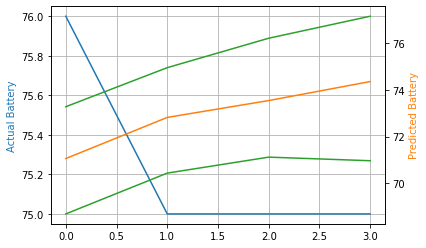

In [54]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Actual Battery', color='C0')
ax2.set_ylabel('Predicted Battery', color='C1')


ax1.plot(actual, color='C0')
ax2.plot(mean, color='C1')
ax2.plot(q01, color='C2')
ax2.plot(q90, color='C2')


# Motor Anomalies

Great job! Now let's work on detecting [motor anomalies](mt-motor-anomaly.ipynb).